<a href="https://colab.research.google.com/github/Balahariharan003/Stock_Price_prodiction_Using_News-and-Prices/blob/main/StockPricePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance pandas numpy matplotlib seaborn scikit-learn tensorflow textblob newsapi-python

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, r2_score
import math

In [ ]:
df = pd.read_csv('/content/SIEMENS.csv')
df.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,1996-01-01,SIEMENS,EQ,487.30,487.30,489.9,485.0,NaN,489.90,487.38,300,1.462150e+10,NaN,NaN,NaN
1,1996-01-02,SIEMENS,EQ,489.90,492.00,492.1,492.0,NaN,492.05,492.05,300,1.476150e+10,NaN,NaN,NaN
2,1996-01-03,SIEMENS,EQ,492.05,492.05,490.0,490.0,NaN,490.00,490.00,100,4.900000e+09,NaN,NaN,NaN
3,1996-01-04,SIEMENS,EQ,490.00,493.95,495.0,490.0,NaN,490.00,493.98,600,2.963850e+10,NaN,NaN,NaN
4,1996-01-05,SIEMENS,EQ,490.00,490.00,490.0,489.9,NaN,490.00,489.96,250,1.224900e+10,NaN,NaN,NaN


In [ ]:
df = df.dropna()

In [ ]:
df = df[df['Volume'] > 0]

In [ ]:
df = df.sort_values('Date')

In [ ]:
data = df[['Open', 'High', 'Low', 'Prev Close', 'Volume', 'VWAP', 'Close']]

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [ ]:
scaled_data = scaler.fit_transform(data)

In [ ]:
X, y = [], []
window_size = 60
for i in range(window_size, len(scaled_data)):
    X.append(scaled_data[i-window_size:i])
    y.append(scaled_data[i, 6])
X, y = np.array(X), np.array(y)

In [ ]:
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [ ]:
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    LSTM(100, return_sequences=False),
    Dropout(0.3),
    Dense(50, activation='relu'),
    Dense(25, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

Epoch 1/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - loss: 4.6431e-04 - val_loss: 0.0010
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - loss: 4.8633e-04 - val_loss: 0.0011
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - loss: 4.3824e-04 - val_loss: 9.8658e-04
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - loss: 4.4498e-04 - val_loss: 0.0013
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - loss: 4.2709e-04 - val_loss: 6.6790e-04
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - loss: 4.4306e-04 - val_loss: 4.9107e-04
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - loss: 4.5717e-04 - val_loss: 0.0010
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - loss: 3.8159e-04 - val_loss: 6.3449e-04
Epoch 9/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - loss: 3.6223e-04 - val_loss: 0.0010
Epoch 10/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - loss: 4.0675e-04 - val_loss: 7.5883e-04
Epoch 11/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - loss: 3.9617e-04 - val_loss: 7.0

In [ ]:
predictions = model.predict(X_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


In [ ]:
dummy = np.zeros((len(predictions), scaled_data.shape[1]))
dummy[:, 6] = predictions[:, 0]
predicted_prices = scaler.inverse_transform(dummy)[:, 6]

In [ ]:
real_prices = data['Prev Close'].values[-len(predictions):]

In [ ]:
rmse = math.sqrt(mean_squared_error(real_prices, predicted_prices))
r2 = r2_score(real_prices, predicted_prices)
actual_trend = np.sign(np.diff(real_prices))
predicted_trend = np.sign(np.diff(predicted_prices))
trend_accuracy = np.mean(actual_trend == predicted_trend) * 100

In [ ]:
print(f"Root Mean Square Error: {rmse}")
print(f"R² Score: {r2}")
print(f"Trend Direction Accuracy: {trend_accuracy:.2f}%")

Root Mean Square Error: 182.615620649351
R² Score: 0.6273941406860786
Trend Direction Accuracy: 86.68%


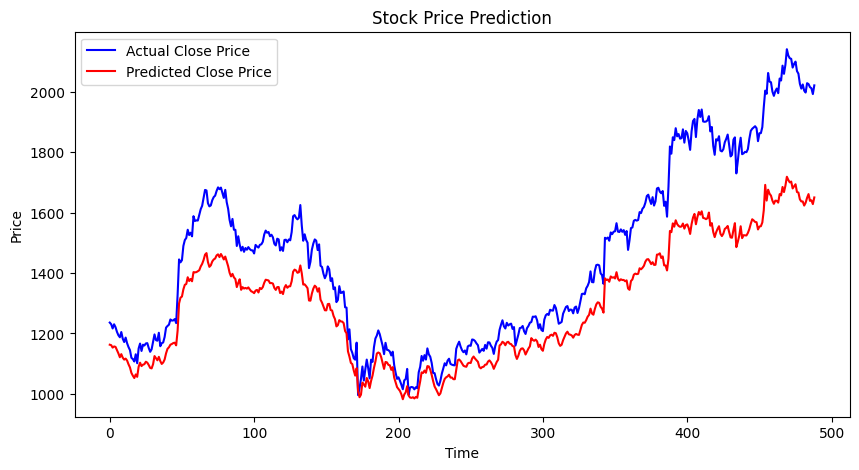

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(real_prices, color='blue', label='Actual Close Price')
plt.plot(predicted_prices, color='red', label='Predicted Close Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


In [ ]:
future_days = 15
last_60_days = scaled_data[-60:]
future_predictions = []

In [ ]:
temp_input = list(last_60_days)

In [ ]:
for i in range(future_days):
    X_future = np.array(temp_input[-60:])
    X_future = np.reshape(X_future, (1, 60, X_future.shape[1]))

    next_pred = model.predict(X_future)
    future_predictions.append(next_pred[0])

    next_pred_full = np.zeros((1, scaled_data.shape[1]))
    next_pred_full[0, 6] = next_pred[0, 0]
    temp_input = np.append(temp_input, next_pred_full, axis=0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


In [ ]:
dummy = np.zeros((len(future_predictions), scaled_data.shape[1]))
for i in range(len(future_predictions)):
    dummy[i, 6] = future_predictions[i][0]
predicted_future_prices = scaler.inverse_transform(dummy)[:, 6]

In [ ]:
print(f"\nPredicted next {future_days} days closing prices:")
for i, price in enumerate(predicted_future_prices, start=1):
    print(f"Day +{i}: ₹{price:.2f}")


📅 Predicted next 15 days closing prices:
Day +1: ₹1645.17
Day +2: ₹1148.69
Day +3: ₹900.73
Day +4: ₹715.96
Day +5: ₹579.32
Day +6: ₹474.48
Day +7: ₹421.71
Day +8: ₹404.67
Day +9: ₹399.14
Day +10: ₹397.88
Day +11: ₹396.86
Day +12: ₹398.36
Day +13: ₹401.42
Day +14: ₹405.26
Day +15: ₹410.35
